In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import re


import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 28
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

In [21]:
import re
import pandas as pd

def extract_info_from_file(filename):
    """
    Extract parameters from the given filename and file content.
    
    Extracted parameters:
      - model: constant "SGFormer"
      - with_features: not in filename (set to None)
      - nc_test_size: not in filename (set to None)
      - Beta_s: extracted from pattern "B_s_"
      - gamma_s: extracted from pattern "g_s_"
      - Ns_obs: extracted from pattern "Ns_obs_"
      - kmean_s: extracted from pattern "k_s_"
      - gamma_n: extracted from pattern "g_n_"
      - kmean_n: extracted from pattern "k_n_"
      - gamma_f: extracted from pattern "g_f_"
      - N_f: extracted from pattern "N_f_"
      - Beta_bi: extracted from pattern "B_bi_"
      - nu: extracted from pattern "nu_"
      - alpha: extracted from pattern "alpha_" (handles negatives via "alpha_neg")
      - N_labels: extracted from pattern "N_l_"
      - i: extracted from pattern "i_"
      - rem_p: extracted from pattern "rand_p_" (if not present, p is assumed to be 0)
      - accuracy: extracted from file content by looking for "Final Test:" value (ignores standard deviation)
    
    Parameters:
        filename (str): The name of the file to process.
    
    Returns:
        dict: A dictionary with all the extracted parameters.
    """
    
    # Define patterns for parameters in the filename (except for alpha which is handled separately)
    patterns = {
        'Beta_s': r'B_s_([\d\.]+)',
        'gamma_s': r'g_s_([\d\.]+)',
        'Ns_obs': r'Ns_obs_([\d\.]+)',
        'kmean_s': r'k_s_([\d\.]+)',
        'gamma_n': r'g_n_([\d\.]+)',
        'kmean_n': r'k_n_([\d\.]+)',
        'gamma_f': r'g_f_([\d\.]+)',
        'N_f': r'N_f_([\d\.]+)',
        'Beta_bi': r'B_bi_([\d\.]+)',
        'nu': r'nu_([\d\.]+)',
        'N_labels': r'N_l_([\d\.]+)',
        'i': r'_i_([\d\.]+)',
        'rem_p': r'rem_p_([\d\.]+)'  # new parameter extraction for rem_p
    }
    
    extracted = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, filename)
        if key == "rand_p":
            # If rand_p is not found, assume p=0.
            extracted[key] = match.group(1) if match else "0"
        else:
            extracted[key] = match.group(1) if match else None

    # Special handling for alpha: it can be like "alpha_5" or "alpha_neg1" (for -1).
    alpha_match = re.search(r'alpha_(neg)?([\d\.]+)', filename)
    if alpha_match:
        if alpha_match.group(1):  # "neg" was found, so use negative value.
            extracted['alpha'] = '-' + alpha_match.group(2)
        else:
            extracted['alpha'] = alpha_match.group(2)
    else:
        extracted['alpha'] = None

    # Set parameters not provided in the filename.
    extracted['with_features'] = None
    extracted['nc_test_size'] = None
    extracted['model'] = "SGFormer"

    # Read file content and extract accuracy (Final Test value).
    try:
        with open(filename, 'r') as file:
            content = file.read()
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        extracted['accuracy'] = None
        return extracted

    # Extract Final Test accuracy (ignoring the standard deviation)
    accuracy_match = re.search(r'Final Test:\s*([\d\.]+)', content)
    if accuracy_match:
        extracted['accuracy'] = accuracy_match.group(1)
    else:
        extracted['accuracy'] = None

    return extracted

def group_and_compute_mean_accuracy(df):
    """
    Group the DataFrame by all parameters except 'i' and 'accuracy',
    then compute the mean accuracy for each group.

    Returns:
        A new DataFrame with the grouped parameters and the mean accuracy.
    """
    # Define the grouping columns (all columns except 'i' and 'accuracy')
    group_columns = [col for col in df.columns if col not in ['i', 'accuracy']]
    
    # Group by these columns and compute the mean of accuracy
    grouped_df = df.groupby(group_columns, as_index=False).mean()
    return grouped_df

def process_files(file_list):
    """
    Process a list of filenames, extract parameters from each file, 
    and return a pandas DataFrame containing the results.
    
    DataFrame columns:
      ['model', 'with_features', 'nc_test_size', 'Beta_s', 'gamma_s', 'Ns_obs', 
       'kmean_s', 'gamma_n', 'kmean_n', 'gamma_f', 'N_f', 'Beta_bi', 'nu', 
       'alpha', 'N_labels', 'i', 'rem_p', 'accuracy']
       
    In case a file does not include 'rand_p' in its name, it is assumed to be 0.
    
    Parameters:
        file_list (list of str): List of filenames to process.
    
    Returns:
        pd.DataFrame: DataFrame with the extracted parameters.
    """
    data = []
    for filename in file_list:
        info = extract_info_from_file(filename)
        data.append(info)
    
    columns = ['model', 'with_features', 'nc_test_size', 'Beta_s', 'gamma_s', 'Ns_obs',
               'kmean_s', 'gamma_n', 'kmean_n', 'gamma_f', 'N_f', 'Beta_bi', 'nu',
               'alpha', 'N_labels', 'i', 'rem_p', 'accuracy']
    df = pd.DataFrame(data, columns=columns)
    
    df['accuracy'] = df['accuracy'].astype(float)
    df['i'] = df['i'].astype(int)
    df['rem_p'] = df['rem_p'].astype(float)
    return df


In [22]:
files = list(glob.glob("/home/rob/repo/SGFormer-HypNF/medium/results_remove_links/*"))

df = process_files(files)
df.head()

,model,with_features,nc_test_size,Beta_s,gamma_s,Ns_obs,kmean_s,gamma_n,kmean_n,gamma_f,N_f,Beta_bi,nu,alpha,N_labels,i,rem_p,accuracy
0,SGFormer,None,None,3,3.5,5000,3,3.5,3,3.5,2000,3,0.0,10,6,2,0.4,78.49
1,SGFormer,None,None,3,3.5,5000,3,3.5,3,3.5,2000,3,0.0,10,6,0,0.2,88.53
2,SGFormer,None,None,3,3.5,5000,3,3.5,3,3.5,2000,3,0.0,10,6,5,0.5,88.53
3,SGFormer,None,None,3,3.5,5000,3,3.5,3,3.5,2000,3,0.0,10,6,9,0.5,89.94
4,SGFormer,None,None,3,3.5,5000,3,3.5,3,3.5,2000,3,0.0,10,6,8,0.5,82.92


In [23]:
def plot_accuracy_vs_rem_p(df):
    # Ensure that 'rand_p' is numeric
    df['rem_p'] = pd.to_numeric(df['rem_p'], errors='coerce')
    
    # Group by 'rand_p' and compute mean and standard deviation for accuracy
    stats = df.groupby('rem_p')['accuracy'].agg(['mean', 'std']).reset_index()
    
    # Create the plot with error bars
    plt.figure(figsize=(8, 6))
    plt.errorbar(stats['rem_p'], stats['mean'], yerr=stats['std'], fmt='o-', capsize=5, markersize=8)
    plt.xlabel('removed fraction')
    plt.ylabel('Accuracy')
#     plt.axhline(100/6, linestyle='--', color='black')

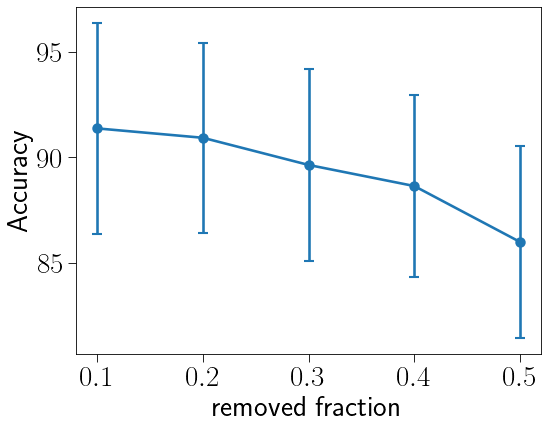

In [24]:
plot_accuracy_vs_rem_p(df)

In [25]:
# df.to_csv("../results/sgformer_nc_remove_links_experiment.csv", header=False)